**Install Required Packages**



In [1]:
!pip install yfinance keras scikit-learn matplotlib

**Import Modules and Set Seeds**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import tensorflow as tf
import datetime
import random

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

**Set reproducibility**

In [5]:
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

**Step 1 - Fetch Stock Data**

In [6]:
ticker = "TCS.NS"
end_date = datetime.datetime.today().strftime('%Y-%m-%d')
data = yf.download(ticker, start="2010-01-01", end=end_date)
data = data[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()
data.tail()

/tmp/ipython-input-6-3811578750.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2010-01-01", end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Open,High,Low,Close,Volume
Ticker,TCS.NS,TCS.NS,TCS.NS,TCS.NS,TCS.NS
Date,,,,,
2025-06-18,3519.100098,3538.000000,3443.100098,3451.399902,2696327
2025-06-19,3450.000000,3451.000000,3413.000000,3424.000000,2672768
2025-06-20,3425.000000,3446.300049,3410.899902,3435.699951,2351248
2025-06-23,3415.000000,3425.000000,3370.000000,3393.600098,3123421
2025-06-24,3434.600098,3442.100098,3382.000000,3390.399902,3403048


**Step 2 - Normalize Input Data**

In [7]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)

**Step 3 - Prepare Sequences**

In [13]:
def prepare_sequences(dataset, label_index=3, window_size=120):
  x, y = [], []
  for i in range(window_size, len(dataset)):
    x.append(dataset[i - window_size:i])
    y.append(dataset[i, label_index])
  return np.array(x), np.array(y)

x_all, y_all = prepare_sequences(scaled, window_size=120)
train_len = int(len(x_all) * 0.8)
x_train, y_train = x_all[:train_len], y_all[:train_len]
x_test, y_test = x_all[train_len:], y_all[train_len:]

**Step 4 - Build the LSTM Model**

In [14]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(128))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**Learning Rate Scheduler**

In [18]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

**Step 5 - Train the Model**




In [19]:
history = model.fit(
    x_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(x_test, y_test),
    callbacks=[reduce_lr],
    verbose=1
)


Epoch 1/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 40s 423ms/step - loss: 3.6023e-04 - val_loss: 4.0771e-04 - learning_rate: 7.8125e-06
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 41s 432ms/step - loss: 4.0266e-04 - val_loss: 4.4346e-04 - learning_rate: 7.8125e-06
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 38s 412ms/step - loss: 3.6040e-04 - val_loss: 4.2085e-04 - learning_rate: 7.8125e-06
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 39s 415ms/step - loss: 3.5907e-04 - val_loss: 3.7775e-04 - learning_rate: 7.8125e-06
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 38s 410ms/step - loss: 3.8071e-04 - val_loss: 3.7270e-04 - learning_rate: 7.8125e-06
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 43s 434ms/step - loss: 3.7769e-04 - val_loss: 3.8868e-04 - learning_rate: 7.8125e-06
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 38s 410ms/step - loss: 4.1185e-04 - val_loss: 3.7539e-04 - learning_rate: 3.9063e-06
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 40s 404ms/step - loss: 4.0537e-04 - val_loss: 4.1950e-04 - learning_rate: 3.9063e-06
Epoch 9/50
93/93

**Step 6 - Predictions and Evaluation**

In [20]:
predicted = model.predict(x_test)
predicted_actual = scaler.inverse_transform(
    np.concatenate([np.zeros((len(predicted), 3)),  # Open, High, Low dummy
                    predicted,
                    np.zeros((len(predicted), 1))], axis=1))[:, 3]

y_test_actual = scaler.inverse_transform(
    np.concatenate([np.zeros((len(y_test), 3)),
                    y_test.reshape(-1, 1),
                    np.zeros((len(y_test), 1))], axis=1))[:, 3]


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step


**Step 7 - Evaluate the Model**

In [21]:
rmse = np.sqrt(mean_squared_error(y_test_actual, predicted_actual))
mae = mean_absolute_error(y_test_actual, predicted_actual)
r2 = r2_score(y_test_actual, predicted_actual)
print("\nModel Evaluation:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")



Model Evaluation:
RMSE: 81.08
MAE: 62.44
R² Score: 0.9652


**Step 8 - Train Predictions**

In [32]:
train_pred = model.predict(x_train)
train_pred_actual = scaler.inverse_transform(np.concatenate([np.zeros((len(train_pred), 3)), train_pred, np.zeros((len(train_pred), 1))], axis=1))[:, 3]
y_train_actual = scaler.inverse_transform(np.concatenate([np.zeros((len(y_train), 3)), y_train.reshape(-1, 1), np.zeros((len(y_train), 1))], axis=1))[:, 3]

train_r2 = r2_score(y_train_actual, train_actual)
print(f"Train R² Score: {train_r2:.4f}")

r2_test = r2_score(y_test_actual, predicted_actual)
print(f"Test R² Score: {r2_test:.4f}")


93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step
Train R² Score: 0.9978
Test R² Score: 0.9652


**Step 9 - Plot Actual vs Predicted Prices**

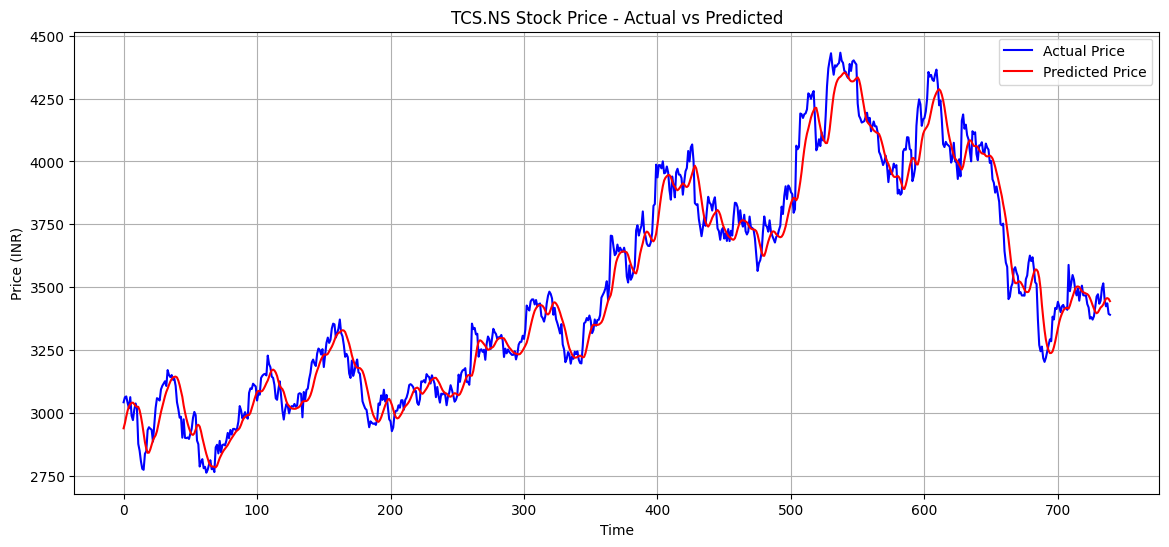

In [28]:
plt.figure(figsize=(14, 6))
plt.plot(y_test_actual, color='blue', label='Actual Price')
plt.plot(predicted_actual, color='red', label='Predicted Price')
plt.title(f"{ticker} Stock Price - Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Price (INR)")
plt.legend()
plt.grid(True)
plt.show()

**Step 10 - Plot Training and Validation Loss**

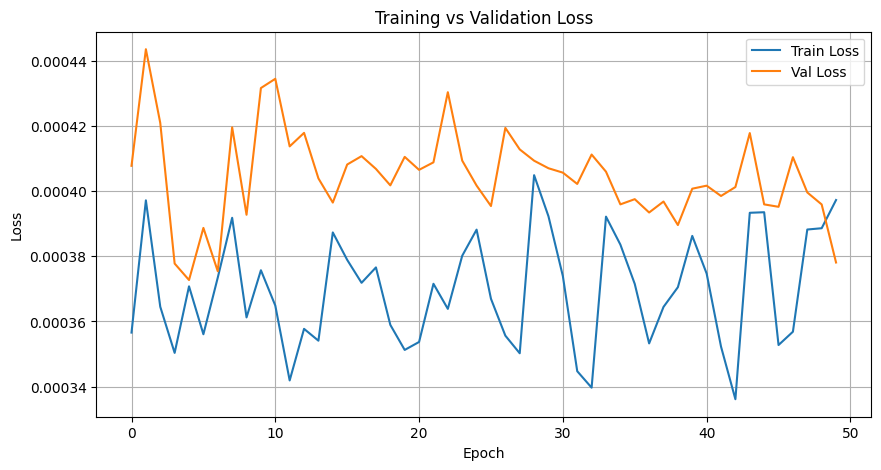

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 6))


**Step 11 - Training Set: Actual vs Predicted**

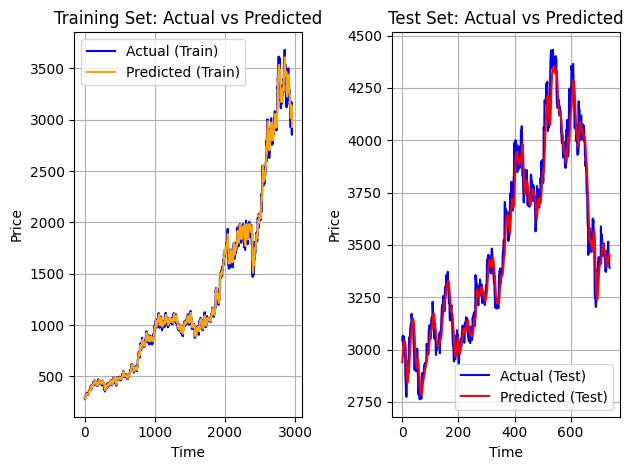

In [33]:
plt.subplot(1, 2, 1)
plt.plot(y_train_actual, label='Actual (Train)', color='blue')
plt.plot(train_pred_actual, label='Predicted (Train)', color='orange')
plt.title("Training Set: Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(y_test_actual, label='Actual (Test)', color='blue')
plt.plot(predicted_actual, label='Predicted (Test)', color='red')
plt.title("Test Set: Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


**Step 12 - Test Set: Actual vs Predicted**

**Step 13 - Save model and scaler**

In [34]:
model.save("lstm_model.h5")
np.save("scaler.npy", scaler.scale_)
np.save("min.npy", scaler.min_)
print("\nModel and scaler saved as lstm_model.h5, scaler.npy, min.npy")


Model and scaler saved as lstm_model.h5, scaler.npy, min.npy
